## 🛠️ Feature Creation

### 📌 What is Feature Creation?

**Feature creation** (also known as *feature engineering*) is the process of **deriving new, meaningful features** from existing ones to enhance a model’s ability to capture important patterns in the data.  
It’s one of the most powerful ways to improve model performance — sometimes **more effective than changing algorithms**.

💡 Think of it as “teaching” the model new concepts by transforming raw data into forms it can learn from more easily.

---

### 🔧 Examples of Feature Creation

#### 🗓️ 1. Date-Time Features
When working with time-based data (e.g., timestamps, transaction dates), you can extract components like:
- `year`, `month`, `day`, `hour`, `day_of_week`
- `is_weekend` (0/1), `is_holiday`  
- Time since last event, time difference between two dates

**Example:**

```python
import pandas as pd

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)



# 🧠 Feature Transformation in Machine Learning

## 📌 Introduction

In machine learning, **feature transformation** refers to changing features to improve performance, stability, and interpretability.  
Raw data often contains features that are **skewed, non-linear, or not on the same scale**.

**Goals:**
- reduce skewness and stabilize variance  
- make distributions closer to normal (when helpful)  
- help linear models capture non-linear relations  
- improve interpretability and convergence


In [24]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

# Synthetic dataset with common quirks
df = pd.DataFrame({
    'positive_long_tail': rng.lognormal(mean=2.0, sigma=1.0, size=200),
    'counts': rng.poisson(lam=8, size=200),
    'mixed_signed': rng.normal(loc=0.0, scale=3.0, size=200),  # has negatives and positives
})

# A toy target with mild nonlinearity
x = np.linspace(0.1, 10, 200)
y = 2*np.log(x) + 0.3*x**0.5 + rng.normal(0, 0.2, size=x.shape[0])
toy = pd.DataFrame({'x': x, 'y': y})

df.head()

,positive_long_tail,counts,mixed_signed
0,10.021343,3,-0.756188
1,2.611738,8,-2.357930
2,15.649691,9,-0.869627
3,18.926531,11,0.595143
4,1.050183,10,-2.301651



## 🔧 Common Feature Transformation Techniques

### 1) Logarithmic Transformation

**Definition**  
$$
x' = \log(x + c)
$$
where $c \ge 0$ handles zeros or negatives (e.g., using $\log(1+x)$ for non-negative $x$).

**Use when** data are **highly positively skewed** or span **orders of magnitude**.


In [25]:
# Example: Log transform on a positive long-tail feature
df_log = df.copy()
df_log['positive_long_tail_log1p'] = np.log1p(df_log['positive_long_tail'])
df_log[['positive_long_tail', 'positive_long_tail_log1p']].head()

,positive_long_tail,positive_long_tail_log1p
0,10.021343,2.399834
1,2.611738,1.284189
2,15.649691,2.812392
3,18.926531,2.992052
4,1.050183,0.717929


Two plots created: raw vs log1p.


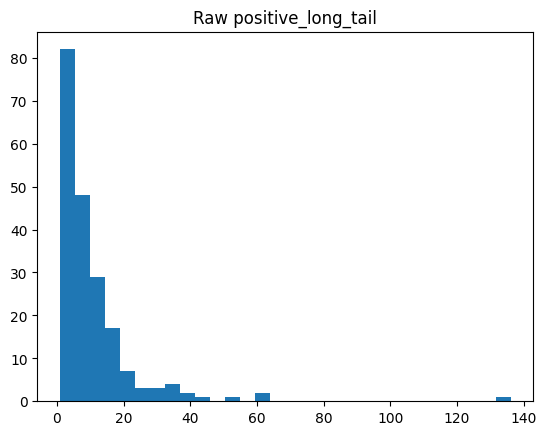

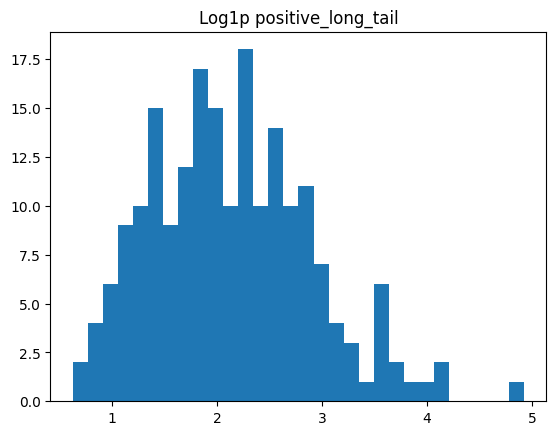

In [26]:
# Visual: compare raw vs log1p
x = df['positive_long_tail'].to_numpy()

plt.figure()
plt.hist(x, bins=30)
plt.title('Raw positive_long_tail')

plt.figure()
plt.hist(np.log1p(x), bins=30)
plt.title('Log1p positive_long_tail')

print("Two plots created: raw vs log1p.")


### 2) Square Root Transformation

**Definition**  
$$
x' = \sqrt{x}
$$

**Use when** data are **counts** or **moderately skewed** (milder than log).


In [27]:
# Example: sqrt on counts
df_sqrt = df.copy()
df_sqrt['counts_sqrt'] = np.sqrt(df_sqrt['counts'])
df_sqrt[['counts', 'counts_sqrt']].head()

,counts,counts_sqrt
0,3,1.732051
1,8,2.828427
2,9,3.000000
3,11,3.316625
4,10,3.162278



### 3) Polynomial & Interaction Transformations

Let models capture curvature and feature interactions.

**Examples (inline):** $x^2$, $x^3$, and an interaction $x_1 x_2$.

**Block:**  
$$
x' = x^2,\quad x'' = x^3,\quad x_{\\text{new}} = x_1 x_2
$$


In [28]:
# Example: polynomial features for a toy x
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(toy[['x']])
pd.DataFrame(X_poly, columns=['x','x^2','x^3']).head()

,x,x^2,x^3
0,0.100000,0.010000,0.001000
1,0.149749,0.022425,0.003358
2,0.199497,0.039799,0.007940
3,0.249246,0.062124,0.015484
4,0.298995,0.089398,0.026730


In [29]:
# Fit linear model with and without polynomial features
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X1 = toy[['x']].values
X3 = X_poly  # x, x^2, x^3

m1 = LinearRegression().fit(X1, toy['y'])
m3 = LinearRegression().fit(X3, toy['y'])

r2_simple = r2_score(toy['y'], m1.predict(X1))
r2_poly3 = r2_score(toy['y'], m3.predict(X3))

r2_simple, r2_poly3

(0.8245595627245282, 0.9656340304099682)


### 4) Box–Cox Transformation (power transform)

**Definition** (for $x>0$)  
$$
x' = 
\begin{cases}
\dfrac{x^\lambda - 1}{\lambda}, & \lambda \ne 0 \\[6pt]
\ln x, & \lambda = 0
\end{cases}
$$

**Use when** data are strictly **positive** and you want a learned power to reduce skewness.


In [30]:
# Example: Box–Cox via sklearn
from sklearn.preprocessing import PowerTransformer

pt_boxcox = PowerTransformer(method='box-cox', standardize=False)
bc = pt_boxcox.fit_transform(df[['positive_long_tail']])
df_bc = df.copy()
df_bc['positive_long_tail_boxcox'] = bc
df_bc[['positive_long_tail','positive_long_tail_boxcox']].head()

,positive_long_tail,positive_long_tail_boxcox
0,10.021343,2.049522
1,2.611738,0.913687
2,15.649691,2.392331
3,18.926531,2.533784
4,1.050183,0.048840



### 5) Yeo–Johnson Transformation

Works with **zero/negative** values.

**Definition** (piecewise; handles $x \le 0$ as well). Often used through libraries.

**Use when** data can be **negative** and you need a learned power transform similar to Box–Cox.


In [31]:
# Example: Yeo–Johnson via sklearn on mixed_signed
pt_yj = PowerTransformer(method='yeo-johnson', standardize=False)
yj = pt_yj.fit_transform(df[['mixed_signed']])
df_yj = df.copy()
df_yj['mixed_signed_yeojohnson'] = yj
df_yj[['mixed_signed','mixed_signed_yeojohnson']].head()

,mixed_signed,mixed_signed_yeojohnson
0,-0.756188,-0.764090
1,-2.357930,-2.416441
2,-0.869627,-0.879827
3,0.595143,0.590122
4,-2.301651,-2.357833



### 6) Quantile & Rank-Gauss (Quantile Normal) Transformations

- **QuantileTransformer** maps data to a target distribution (uniform or normal) using quantiles.  
- **Rank-Gauss** (Gaussian rank) maps ranks to a standard normal via the inverse CDF.

These are powerful for taming outliers and heavy tails.


In [32]:
# QuantileTransformer to normal
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal', random_state=0)
qt_norm = qt.fit_transform(df[['positive_long_tail']])
df_qt = df.copy()
df_qt['positive_long_tail_qt_normal'] = qt_norm
df_qt[['positive_long_tail','positive_long_tail_qt_normal']].head()

c:\Users\MOBIT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (200). n_quantiles is set to n_samples.
  warnings.warn(


,positive_long_tail,positive_long_tail_qt_normal
0,10.021343,0.394154
1,2.611738,-1.197387
2,15.649691,0.931183
3,18.926531,1.197387
4,1.050183,-2.574096


In [33]:
# Rank-Gauss (manual): rank -> (0,1) -> inverse normal CDF
import scipy.stats as st

vals = df['positive_long_tail'].to_numpy()
ranks = st.rankdata(vals, method='average')
u = (ranks - 0.5) / len(ranks)  # in (0,1)
gauss = st.norm.ppf(u)
rg = pd.Series(gauss, name='positive_long_tail_rankgauss')

pd.concat([df['positive_long_tail'].reset_index(drop=True), rg], axis=1).head()

,positive_long_tail,positive_long_tail_rankgauss
0,10.021343,0.392079
1,2.611738,-1.187577
2,15.649691,0.924934
3,18.926531,1.187577
4,1.050183,-2.432379



### 7) Scaling (Standard / MinMax / Robust)

- **StandardScaler:** center and scale to unit variance.  
- **MinMaxScaler:** map to a fixed range (e.g., [0,1]).  
- **RobustScaler:** robust to outliers (median/IQR).

Scaling is not a distribution fix, but many algorithms benefit from consistent feature scales.


In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

sc_std = StandardScaler()
sc_mm = MinMaxScaler()
sc_rb = RobustScaler()

scaled = pd.DataFrame({
    'std_mixed': sc_std.fit_transform(df[['mixed_signed']]).ravel(),
    'mm_mixed': sc_mm.fit_transform(df[['mixed_signed']]).ravel(),
    'rb_mixed': sc_rb.fit_transform(df[['mixed_signed']]).ravel(),
})
scaled.head()

,std_mixed,mm_mixed,rb_mixed
0,-0.301804,0.430424,-0.288860
1,-0.871436,0.332626,-0.726764
2,-0.342147,0.423498,-0.319873
3,0.178774,0.512933,0.080584
4,-0.851421,0.336062,-0.711378



### 8) Binning / Discretization

Turn continuous variables into bins—useful for tree models or when non-linear thresholds matter.

$$
x' = \\text{bin}(x; K)
$$


In [35]:
from sklearn.preprocessing import KBinsDiscretizer

kbd = KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile')
binned = kbd.fit_transform(df[['positive_long_tail']])
binned[:5]

c:\Users\MOBIT\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_discretization.py:296: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.]])


## 🎯 Target Transformation (Supervised)

Sometimes transforming **y** helps more than transforming **X** (e.g., log-target in regression).  
Sklearn offers `TransformedTargetRegressor`.


Plot created for target-transformed regression.


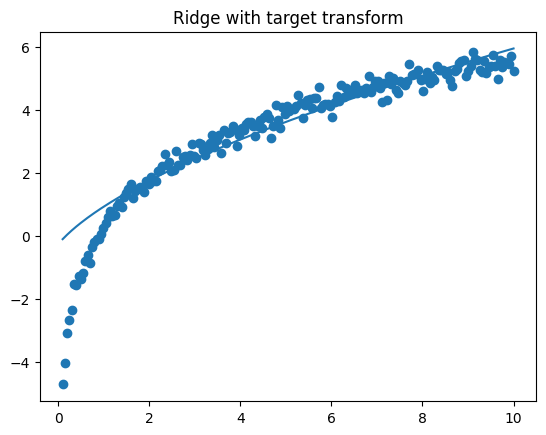

In [36]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge

reg = TransformedTargetRegressor(
    regressor=Ridge(),
    transformer=PowerTransformer(method='yeo-johnson')
)
reg.fit(toy[['x']], toy['y'])
pred = reg.predict(toy[['x']])

plt.figure()
plt.scatter(toy['x'], toy['y'])
plt.plot(toy['x'], pred)
plt.title('Ridge with target transform')
print("Plot created for target-transformed regression.")


## 📊 Practical Guidelines

- **Log / Box–Cox / Yeo–Johnson** for skewed features (choose per sign constraints).  
- **Quantile/Ranks** when you need strong outlier control and near-normal outputs.  
- **Polynomial/Interactions** when relationships are non-linear but you stick with linear models.  
- **Scaling** for algorithms sensitive to feature scales (SVM, KNN, NN, linear models with regularization).  
- **Binning** for threshold effects or tree-based pipelines.  
- **Transform y** when residuals are skewed or variance is non-constant.



## ✅ Summary

Feature transformations help:
- reduce skewness and stabilize variance  
- align data with model assumptions  
- expose non-linear structure via engineered terms  
- standardize scales for optimization

Choose based on **distribution**, **model family**, and **interpretability** needs.


In [37]:
import pandas as pd

df = pd.read_csv('bike_sharing_daily.csv')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
None


In [38]:
print("\n Dataset Preview: ")
print(df.head())


 Dataset Preview: 
   instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1        0        6           0   
1        2  2011-01-02       1   0     1        0        0           0   
2        3  2011-01-03       1   0     1        0        1           1   
3        4  2011-01-04       1   0     1        0        2           1   
4        5  2011-01-05       1   0     1        0        3           1   

   weathersit      temp     atemp       hum  windspeed  casual  registered  \
0           2  0.344167  0.363625  0.805833   0.160446     331         654   
1           2  0.363478  0.353739  0.696087   0.248539     131         670   
2           1  0.196364  0.189405  0.437273   0.248309     120        1229   
3           1  0.200000  0.212122  0.590435   0.160296     108        1454   
4           1  0.226957  0.229270  0.436957   0.186900      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  


In [39]:
# Covert dteday to datetime
df['dteday'] = pd.to_datetime(df['dteday'])

# Create New features
df['day_of_week'] = df['dteday'].dt.day_name()

# Create new features
df['day_of_week'] = df['dteday'].dt.day_name()
df['month'] = df['dteday'].dt.month
df['year'] = df['dteday'].dt.year

# Display the new features
print("\n New Features Derived from Date Column")
print(df[['dteday', 'day_of_week', 'month', 'year']].head())




 New Features Derived from Date Column
      dteday day_of_week  month  year
0 2011-01-01    Saturday      1  2011
1 2011-01-02      Sunday      1  2011
2 2011-01-03      Monday      1  2011
3 2011-01-04     Tuesday      1  2011
4 2011-01-05   Wednesday      1  2011


In [40]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Select feature and target
X = df[['temp']]
y  = df['cnt']

# Apply polynomial transformation
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Display the trasformed feature
print("\n Orginal and Polynomial Features")
print(pd.DataFrame(X_poly, columns=['temp', 'temp^2']).head())


 Orginal and Polynomial Features
       temp    temp^2
0  0.344167  0.118451
1  0.363478  0.132116
2  0.196364  0.038559
3  0.200000  0.040000
4  0.226957  0.051509


In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, X_test)
y_pred_original = model.predict(X_test)

mse_original = mean_squared_error(y_test, y_pred_original)

ValueError: Found input variables with inconsistent numbers of samples: [584, 147]

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train_poly, X_test_poly)  
y_pred_poly = model.predict(X_test_poly)

mse_original = mean_squared_error(y_test_poly, y_pred_poly)

ValueError: Found input variables with inconsistent numbers of samples: [584, 147]